# 11.3. 梯度下降

尽管**梯度下降**（gradient descent）很少直接用于深度学习，但了解它是理解下一节随机梯度下降算法的关键。例如，由于学习率过大，优化问题可能会发散，这种现象早已在梯度下降中出现。同样地，**预处理**（preconditioning）是梯度下降中的一种常用技术，还被沿用到更高级的算法中。让我们从简单的一维梯度下降开始。

## 11.3.1. 一维梯度下降

为什么梯度下降算法可以优化目标函数？一维中的梯度下降给我们很好的启发。考虑一类连续可微实值函数$f: \mathbb{R} \rightarrow \mathbb{R}$，利用泰勒展开，我们可以得到

$$f(x + \epsilon) = f(x) + \epsilon f'(x) + \mathcal{O}(\epsilon^2).\tag{11.3.1}$$


即在一阶近似中，$f(x+\epsilon)$可通过$x$处的函数值$f(x)$和一阶导数$f'(x)$得出。我们可以假设在负梯度方向上移动的$\epsilon$会减少$f$。为了简单起见，我们选择固定步长$\eta > 0$，然后取$\epsilon = -\eta f'(x)$。将其代入泰勒展开式我们可以得到

$$f(x - \eta f'(x)) = f(x) - \eta f'^2(x) + \mathcal{O}(\eta^2 f'^2(x)). \tag{11.3.2}$$


如果其导数$f'(x) \neq 0$没有消失，我们就能继续展开，这是因为$\eta f'^2(x)>0$。此外，我们总是可以令$\eta$小到足以使高阶项变得不相关。因此，

$$f(x - \eta f'(x)) \lessapprox f(x). \tag{11.3.3}$$

这意味着，如果我们使用

$$x \leftarrow x - \eta f'(x) \tag{11.3.4}$$

来迭代$x$，函数$f(x)$的值可能会下降。因此，在梯度下降中，我们首先选择初始值$x$和常数$\eta > 0$，然后使用它们连续迭代$x$，直到停止条件达成。例如，当梯度$|f'(x)|$的幅度足够小或迭代次数达到某个值时。

下面我们来展示如何实现梯度下降。为了简单起见，我们选用目标函数$f(x)=x^2$。尽管我们知道$x=0$时$f(x)$能取得最小值，但我们仍然使用这个简单的函数来观察$x$的变化。

In [1]:
%matplotlib inline
import numpy as np
import torch
from d2l import torch as d2l

def f(x): # 目标函数
    return x ** 2

def f_grad(x): # 目标函数的梯度(导数)
    return 2*x

"""
接下来，我们使用x=10作为初始值，并假设n(学习率)=0.2。 使用梯度下降法迭代x共10次，我们可以看到，x的值最终将接近最优解。
"""
def gd(eta,f_grad):  # 将函数作为参数传递
    x=10.0
    results=[x]
    for i in range(10):
        x -= eta * f_grad(x)
        results.append(float(x))
    print(f'epoch 10, x:{x:f}')
    return results

results=gd(0.2,f_grad)


epoch 10, x:0.060466


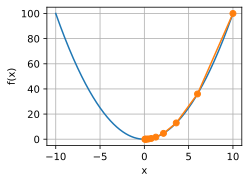

In [2]:
"""
对x进行优化的过程可以绘制如下。
"""
def show_trace(results,f):
    n=max(abs(min(results)),abs(max(results)))
    f_line=torch.arange(-n,n,0.01)
    d2l.set_figsize()
    d2l.plot([f_line,results],[[f(x) for x in f_line],[f(x) for x in results]],'x','f(x)',fmts=['-','-o'])

show_trace(results,f)

### 学习率
**学习率**（learning rate）决定目标函数能否收敛到局部最小值，以及何时收敛到最小值。学习率$\eta$可由算法设计者设置。请注意，如果我们使用的学习率太小，将导致$x$的更新非常缓慢，需要更多的迭代。例如，考虑同一优化问题中$\eta = 0.05$的进度。如下所示，尽管经过了10个步骤，我们仍然离最优解很远。

epoch 10, x:3.486784


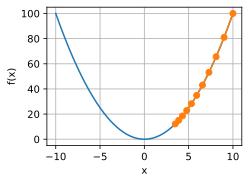

In [3]:
show_trace(gd(0.05,f_grad),f)

相反，如果我们使用过高的学习率，$\left|\eta f'(x)\right|$对于一阶泰勒展开式可能太大。也就是说，公式11.3.1中的$\mathcal{O}(\eta^2 f'^2(x))$可能变得显著了。在这种情况下，$x$的迭代不能保证降低$f(x)$的值。例如，当学习率为$\eta=1.1$时，$x$超出了最优解$x=0$并逐渐发散。

epoch 10, x:61.917364


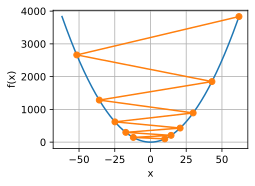

In [4]:
show_trace(gd(1.1,f_grad),f)

### 局部最小值
为了演示非凸函数的梯度下降，考虑函数$f(x) = x \cdot \cos(cx)$，其中$c$为某常数。这个函数有无穷多个局部最小值。根据我们选择的学习率，我们最终可能只会得到许多解的一个。下面的例子说明了（不切实际的）高学习率如何导致较差的局部最小值。

epoch 10, x:-1.528166


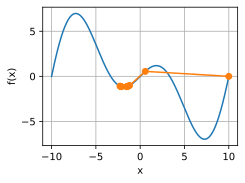

In [5]:
c=torch.tensor(0.15*np.pi)  # tensor(0.4712)

def f(x):  # 目标函数
    return x*torch.cos(c*x)

def f_grad(x):  # 目标函数的梯度(导数)
    return torch.cos(c*x)-c*x*torch.sin(c*x)

show_trace(gd(2,f_grad),f)

epoch 10, x:7.330616


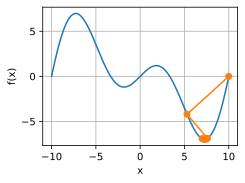

In [6]:
show_trace(gd(1,f_grad),f)

epoch 10, x:7.269388


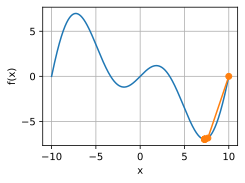

In [7]:
show_trace(gd(0.5,f_grad),f)

## 11.3.2. 多元梯度下降
现在我们对单变量的情况有了更好的理解，让我们考虑一下$\mathbf{x} = [x_1, x_2, \ldots, x_d]^\top$的情况。即目标函数$f: \mathbb{R}^d \to \mathbb{R}$将向量映射成标量。相应地，它的梯度也是多元的：它是一个由$d$个偏导数组成的向量：

$$\nabla f(\mathbf{x}) = \bigg[\frac{\partial f(\mathbf{x})}{\partial x_1}, \frac{\partial f(\mathbf{x})}{\partial x_2}, \ldots, \frac{\partial f(\mathbf{x})}{\partial x_d}\bigg]^\top.\tag{11.3.5}$$

梯度中的每个偏导数元素$\partial f(\mathbf{x})/\partial x_i$代表了当输入$x_i$时$f$在$\mathbf{x}$处的变化率。和先前单变量的情况一样，我们可以对多变量函数使用相应的泰勒近似来思考。具体来说，

$$f(\mathbf{x} + \boldsymbol{\epsilon}) = f(\mathbf{x}) + \mathbf{\boldsymbol{\epsilon}}^\top \nabla f(\mathbf{x}) + \mathcal{O}(\|\boldsymbol{\epsilon}\|^2). \tag{11.3.6}$$


换句话说，在$\boldsymbol{\epsilon}$的二阶项中，最陡下降的方向由负梯度$-\nabla f(\mathbf{x})$得出。选择合适的学习率$\eta > 0$来生成典型的梯度下降算法：

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f(\mathbf{x}).\tag{11.3.7}$$

这个算法在实践中的表现如何呢？我们构造一个目标函数$f(\mathbf{x})=x_1^2+2x_2^2$，并有二维向量$\mathbf{x} = [x_1, x_2]^\top$作为输入，标量作为输出。梯度由$\nabla f(\mathbf{x}) = [2x_1, 4x_2]^\top$给出。我们将从初始位置$[-5, -2]$通过梯度下降观察$\mathbf{x}$的轨迹。

我们还需要两个辅助函数：第一个是update函数，并将其应用于初始值20次；第二个函数会显示$\mathbf{x}$的轨迹。

epoch 20, x1:-0.057646, x2:-0.000073


/home/zhang/anaconda3/envs/d2l/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352463056/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


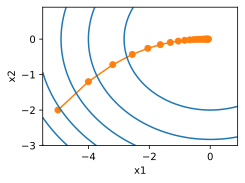

In [9]:
def train_2d(trainer,steps=20,f_grad=None):  #@save
    """用定制的训练机优化2D目标函数"""

    # s1和s2是稍后将使用的内部状态变量
    x1,x2,s1,s2=-5,-2,0,0
    results=[(x1,x2)]
    for i in range(steps):
        if f_grad:
            x1,x2,s1,s2=trainer(x1,x2,s1,s2,f_grad)
        else:
            x1,x2,s1,s2=trainer(x1,x2,s1,s2)
        results.append((x1,x2))
    print(f'epoch {i+1}, x1:{float(x1):f}, x2:{float(x2):f}')
    return results


def show_trace_2D(f,results):  #@save
    """"""
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results),'-o',color='#ff7f0e')
    x1,x2=torch.meshgrid(torch.arange(-5.5,1.0,0.1),
                         torch.arange(-3.0,1.0,0.1))
    d2l.plt.contour(x1,x2,f(x1,x2),colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

"""
接下来，我们观察学习率n=0.1时优化变量的轨迹。 可以看到，经过20步之后，x的值接近其位于[0,0]的最小值。 虽然进展相当顺利，但相当缓慢。
"""
def f_2d(x1,x2):
    return x1 ** 2+2*x2**2

def f_2d_grad(x1,x2):
    return (2*x1,4*x2)

def gd_2d(x1,x2,s1,s2,f_grad):
    g1,g2=f_grad(x1,x2)
    return (x1-eta*g1,x2-eta*g2,0,0)

eta=0.1

show_trace_2D(f_2d,train_2d(gd_2d,f_grad=f_2d_grad))


## 11.3.3. 自适应方法
正如我们在11.3.1.1节中所看到的，选择“恰到好处”的学习率$\eta$是很棘手的。如果我们把它选得太小，就没有什么进展；如果太大，得到的解就会振荡，甚至可能发散。如果我们可以自动确定$\eta$，或者完全不必选择学习率，会怎么样？**除了考虑目标函数的值和梯度、还考虑它的曲率的二阶方法可以帮我们解决这个问题**。虽然由于计算代价的原因，这些方法不能直接应用于深度学习，但它们为如何设计高级优化算法提供了有用的思维直觉，这些算法可以模拟下面概述的算法的许多理想特性。

### 牛顿法

回顾一些函数$f: \mathbb{R}^d \rightarrow \mathbb{R}$的泰勒展开式，事实上我们可以把它写成

$$f(\mathbf{x} + \boldsymbol{\epsilon}) = f(\mathbf{x}) + \boldsymbol{\epsilon}^\top \nabla f(\mathbf{x}) + \frac{1}{2} \boldsymbol{\epsilon}^\top \nabla^2 f(\mathbf{x}) \boldsymbol{\epsilon} + \mathcal{O}(\|\boldsymbol{\epsilon}\|^3).\tag{11.3.8}$$

为了避免繁琐的符号，我们将$\mathbf{H} \stackrel{\mathrm{def}}{=} \nabla^2 f(\mathbf{x})$定义为$f$的Hessian，是$d \times d$矩阵。当$d$的值很小且问题很简单时，$\mathbf{H}$很容易计算。但是对于深度神经网络而言，考虑到$\mathbf{H}$可能非常大，$\mathcal{O}(d^2)$个条目的存储代价会很高，此外通过反向传播进行计算可能雪上加霜。然而，我们姑且先忽略这些考量，看看会得到什么算法。


毕竟，$f$的最小值满足$\nabla f = 0$。遵循2.4节中的微积分规则，通过取$\boldsymbol{\epsilon}$对公式11.3.8的导数，再忽略不重要的高阶项，我们便得到

$$\nabla f(\mathbf{x}) + \mathbf{H} \boldsymbol{\epsilon} = 0 \text{ and hence }
\boldsymbol{\epsilon} = -\mathbf{H}^{-1} \nabla f(\mathbf{x}).\tag{11.3.9}$$

也就是说，作为优化问题的一部分，我们需要将Hessian矩阵$\mathbf{H}$求逆。

举一个简单的例子，对于$f(x) = \frac{1}{2} x^2$，我们有$\nabla f(x) = x$和$\mathbf{H} = 1$。因此，对于任何$x$，我们可以获得$\epsilon = -x$。换言之，单单一步就足以完美地收敛，而无须任何调整。我们在这里比较幸运：泰勒展开式是确切的，因为$f(x+\epsilon)= \frac{1}{2} x^2 + \epsilon x + \frac{1}{2} \epsilon^2$。

让我们看看其他问题。给定一个凸双曲余弦函数$c$，其中$c$为某些常数，我们可以看到经过几次迭代后，得到了$x=0$处的全局最小值。

epoch 10, x: tensor(0.)


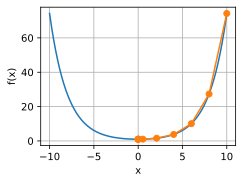

In [10]:
c = torch.tensor(0.5)

def f(x):  # O目标函数
    return torch.cosh(c * x)

def f_grad(x):  # 目标函数的梯度
    return c * torch.sinh(c * x)

def f_hess(x):  # 目标函数的Hessian
    return c**2 * torch.cosh(c * x)

def newton(eta=1):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x) / f_hess(x)
        results.append(float(x))
    print('epoch 10, x:', x)
    return results

show_trace(newton(), f)

现在让我们考虑一个非凸函数，比如$f(x) = x \cos(c x)$，$c$为某些常数。请注意在牛顿法中，我们最终将除以Hessian。这意味着如果二阶导数是负的，$f$的值可能会趋于增加。这是这个算法的致命缺陷！让我们看看实践中会发生什么。

epoch 10, x: tensor(26.8341)


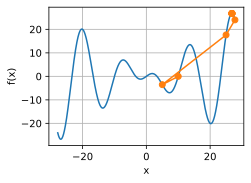

In [11]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # 目标函数
    return x * torch.cos(c * x)

def f_grad(x):  # 目标函数的梯度
    return torch.cos(c * x) - c * x * torch.sin(c * x)

def f_hess(x):  # 目标函数的Hessian
    return - 2 * c * torch.sin(c * x) - x * c**2 * torch.cos(c * x)

show_trace(newton(), f)

这发生了惊人的错误。我们怎样才能修正它？一种方法是**用取Hessian的绝对值来修正**，另一个策略是**重新引入学习率**。这似乎违背了初衷，但不完全是————拥有二阶信息可以使我们在曲率较大时保持谨慎，而在目标函数较平坦时则采用较大的学习率。让我们看看在学习率稍小的情况下它是如何生效的，比如$\eta = 0.5$。如我们所见，我们有了一个相当高效的算法。

epoch 10, x: tensor(7.2699)


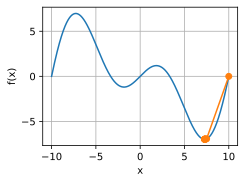

In [12]:
show_trace(newton(0.5), f)

### 收敛性分析
在此，我们以部分目标凸函数$f$为例，分析它们的牛顿法收敛速度。这些目标凸函数三次可微，而且二阶导数不为零，即$f'' > 0$。由于多变量情况下的证明是对以下一维参数情况证明的直接拓展，对我们理解这个问题不能提供更多帮助，因此我们省略了多变量情况的证明。

用$x^{(k)}$表示$x$在第$k^\mathrm{th}$次迭代时的值，令$e^{(k)} \stackrel{\mathrm{def}}{=} x^{(k)} - x^*$表示$k^\mathrm{th}$迭代时与最优性的距离。通过泰勒展开，我们得到条件$f'(x^*) = 0$可以写成

$$0 = f'(x^{(k)} - e^{(k)}) = f'(x^{(k)}) - e^{(k)} f''(x^{(k)}) + \frac{1}{2} (e^{(k)})^2 f'''(\xi^{(k)}), \tag{11.3.10}$$

这对某些$\xi^{(k)} \in [x^{(k)} - e^{(k)}, x^{(k)}]$成立。将上述展开除以$f''(x^{(k)})$得到

$$e^{(k)} - \frac{f'(x^{(k)})}{f''(x^{(k)})} = \frac{1}{2} (e^{(k)})^2 \frac{f'''(\xi^{(k)})}{f''(x^{(k)})}.\tag{11.3.11}$$

回想之前的方程$x^{(k+1)} = x^{(k)} - f'(x^{(k)}) / f''(x^{(k)})$。代入这个更新方程，取两边的绝对值，我们得到

$$\left|e^{(k+1)}\right| = \frac{1}{2}(e^{(k)})^2 \frac{\left|f'''(\xi^{(k)})\right|}{f''(x^{(k)})}.\tag{11.3.12}$$

因此，每当我们处于有界区域$\left|f'''(\xi^{(k)})\right| / (2f''(x^{(k)})) \leq c$，我们就有一个二次递减误差

$$\left|e^{(k+1)}\right| \leq c (e^{(k)})^2.\tag{11.3.13}$$

另一方面，优化研究人员称之为“线性”收敛，而将$\left|e^{(k+1)}\right| \leq \alpha \left|e^{(k)}\right|$这样的条件称为“恒定”收敛速度。请注意，我们无法估计整体收敛的速度，但是一旦我们接近极小值，收敛将变得非常快。另外，这种分析要求$f$在高阶导数上表现良好，即确保$f$在如何变化它的值方面没有任何“超常”的特性。

### 预处理

计算和存储完整的Hessian非常昂贵，而改善这个问题的一种方法是“预处理”。它回避了计算整个Hessian，而**只计算“对角线”项**，即如下的算法更新：

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \mathrm{diag}(\mathbf{H})^{-1} \nabla f(\mathbf{x}).\tag{11.3.14}$$

虽然这不如完整的牛顿法精确，但它仍然比不使用要好得多。为什么预处理有效呢？假设一个变量以毫米表示高度，另一个变量以公里表示高度的情况。假设这两种自然尺度都以米为单位，那么我们的参数化就出现了严重的不匹配。幸运的是，使用预处理可以消除这种情况。梯度下降的有效预处理相当于为每个变量选择不同的学习率（矢量$\mathbf{x}$的坐标）。我们将在后面一节看到，预处理推动了随机梯度下降优化算法的一些创新。

### 梯度下降和线搜索

梯度下降的一个关键问题是我们可能会超过目标或进展不足，解决这一问题的简单方法是结合使用线搜索和梯度下降。也就是说，我们使用$\nabla f(\mathbf{x})$给出的方向，然后进行二分搜索，以确定哪个学习率$\eta$使$f(\mathbf{x} - \eta \nabla f(\mathbf{x}))$取最小值。

有关分析和证明，此算法收敛迅速（请参见`Boyd.Vandenberghe.2004`）。然而，对深度学习而言，这不太可行。因为线搜索的每一步都需要评估整个数据集上的目标函数，实现它的方式太昂贵了。

## 11.3.4. 小结

* 学习率的大小很重要：学习率太大会使模型发散，学习率太小会没有进展。
* 梯度下降会可能陷入局部极小值，而得不到全局最小值。
* 在高维模型中，调整学习率是很复杂的。
* 预处理有助于调节比例。
* 牛顿法在凸问题中一旦开始正常工作，速度就会快得多。
* 对于非凸问题，不要不作任何调整就使用牛顿法。